In [24]:
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3 import PPO

from gym_anytrading.envs import StocksEnv

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [23]:
checkpoint_callback = CheckpointCallback(save_freq=1e4, save_path='./model_checkpoints/')

In [95]:
# Function to detect and adjust stock splits
# Function to detect and adjust stock splits for all stocks in the dataset
def detect_and_adjust_splits_for_all_stocks(df):
    # Sort by stock_ticker and date to ensure proper comparison for each stock
    df = df.sort_values(by=['stock_ticker', 'date']).copy()

    # Iterate through each stock group identified by 'stock_ticker'
    for stock_ticker, stock_data in df.groupby('stock_ticker'):
        stock_data = stock_data.sort_values(by='date')

        # Iterate over the rows for the current stock to check for splits
        for i in range(1, len(stock_data)):
            prev_price = stock_data.iloc[i - 1]['prc']
            current_price = stock_data.iloc[i]['prc']
            prev_market_equity = stock_data.iloc[i - 1]['market_equity']
            current_market_equity = stock_data.iloc[i]['market_equity']

            # Detect a significant drop in price with a stable market equity
            if prev_price > current_price * 2 and abs(prev_market_equity - current_market_equity) < 0.1 * prev_market_equity:
                split_ratio = round(prev_price / current_price)
                print(f"Stock split detected for {stock_ticker} on {stock_data.iloc[i]['date']} with a ratio of {split_ratio}-for-1")

                # Adjust all previous prices for this stock according to the split ratio
                df.loc[(df['stock_ticker'] == stock_ticker) & (df['date'] <= stock_data.iloc[i]['date']), 'prc'] /= split_ratio

    return df

In [96]:
df = pd.read_csv("hackathon_sample_v2.csv")
dfList = []
stockNames = df['stock_ticker'].unique().tolist()

for ticker in stockNames:
    dfList.append(df[df['stock_ticker'] == ticker])

df = pd.concat(dfList)
df = detect_and_adjust_splits_for_all_stocks(df)

Stock split detected for AA on 20000731 with a ratio of 2-for-1
Stock split detected for AAP on 20040227 with a ratio of 2-for-1
Stock split detected for AAPL on 20140731 with a ratio of 7-for-1
Stock split detected for ABC on 20090731 with a ratio of 2-for-1
Stock split detected for ADAP on 20000428 with a ratio of 2-for-1
Stock split detected for ADBE on 20001130 with a ratio of 2-for-1
Stock split detected for ADTN on 20040130 with a ratio of 2-for-1
Stock split detected for ADVP on 20011231 with a ratio of 2-for-1
Stock split detected for AFL on 20010430 with a ratio of 2-for-1
Stock split detected for AFL on 20180430 with a ratio of 2-for-1
Stock split detected for AGN on 20070731 with a ratio of 2-for-1
Stock split detected for ALK on 20140829 with a ratio of 2-for-1
Stock split detected for ALXN on 20080930 with a ratio of 2-for-1
Stock split detected for ALXN on 20110630 with a ratio of 2-for-1
Stock split detected for ANAD on 20000428 with a ratio of 2-for-1
Stock split detect

In [97]:
df

,date,ret_eom,permno,shrcd,exchcd,mspread,year,month,size_port,rf,...,betadown_252d,bidaskhl_21d,corr_1260d,betabab_1260d,rmax5_rvol_21d,age,qmj,qmj_prof,qmj_growth,qmj_safety
14377,20001229,20001231,87432,11,1,0.016473,2000,12,B,0.0050,...,2.234551,0.013440,NaN,NaN,1.267846,35,NaN,1.119352,NaN,1.643064
15502,20010131,20010131,87432,11,1,0.011525,2001,1,B,0.0054,...,2.160193,0.016473,NaN,NaN,0.972802,36,NaN,1.115908,NaN,1.641713
16617,20010228,20010228,87432,11,1,0.009882,2001,2,B,0.0038,...,2.209745,0.011525,NaN,NaN,1.010576,37,NaN,1.116300,NaN,1.637343
17688,20010330,20010331,87432,11,1,0.015782,2001,3,B,0.0042,...,2.444064,0.009882,NaN,NaN,0.741048,38,NaN,1.373031,NaN,1.578964
18734,20010430,20010430,87432,11,1,0.018775,2001,4,B,0.0039,...,2.223938,0.015782,NaN,NaN,1.251023,39,NaN,1.374396,NaN,1.578721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268385,20230831,20230831,13305,11,1,0.007623,2023,8,B,0.0045,...,1.247594,0.004564,0.671186,1.299755,1.611774,163,-0.610793,0.352985,-0.935608,-0.036016
269407,20230929,20230930,13305,11,1,0.004933,2023,9,B,0.0043,...,1.145259,0.007623,0.672056,1.302454,0.434724,164,-0.602658,0.339540,-0.934711,-0.011472
270425,20231031,20231031,13305,11,1,0.005457,2023,10,B,0.0047,...,1.094390,0.004933,0.672301,1.345981,0.408287,165,-0.601575,0.339696,-0.939739,-0.005752
271433,20231130,20231130,13305,11,1,0.004726,2023,11,B,0.0044,...,1.060510,0.005457,0.665731,1.350127,0.865284,166,-0.285945,0.556308,-0.695799,0.157076


In [98]:
df = df.fillna(0)

<Axes: >

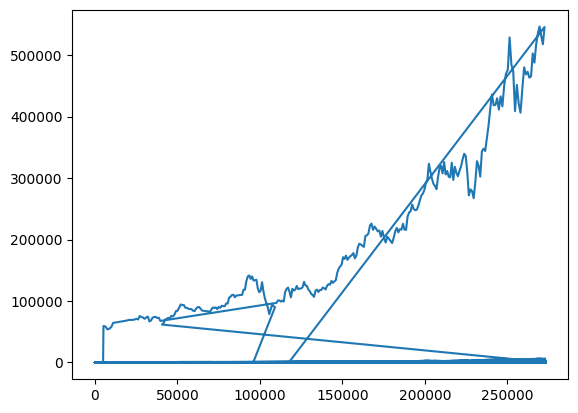

In [99]:
df['prc'].plot()

<Axes: >

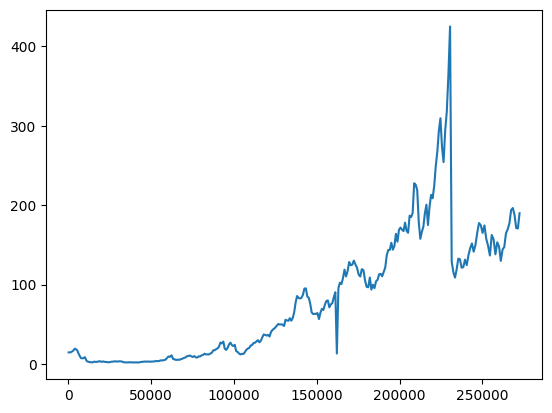

In [100]:
df[df['stock_ticker'] == 'AAPL']['prc'].plot()

In [101]:
len(df['stock_ticker'].unique().tolist())

3565

In [102]:
def personal_process_data(df, window_size, stockTickers, frame_bound):
    start = frame_bound[0] - window_size
    end = frame_bound[1]



    prices = df.loc[:, 'prc'].to_numpy()[start:end]
    signal_features = df.loc[:, [
            'age', 'aliq_at', 'aliq_mat', 'ami_126d', 'at_be', 'at_gr1', 'at_me', 'at_turnover', 'be_gr1a', 'be_me', 'beta_60m', 'beta_dimson_21d', 'betabab_1260d', 
            'betadown_252d', 'bev_mev', 'bidaskhl_21d', 'capex_abn', 'capx_gr1', 'capx_gr2', 'capx_gr3', 'cash_at', 'chcsho_12m', 'coa_gr1a', 'col_gr1a', 'cop_at', 
            'cop_atl1', 'corr_1260d', 'coskew_21d', 'cowc_gr1a', 'dbnetis_at', 'debt_gr3', 'debt_me', 'dgp_dsale', 'div12m_me', 'dolvol_126d', 'dolvol_var_126d', 
            'dsale_dinv', 'dsale_drec', 'dsale_dsga', 'earnings_variability', 'ebit_bev', 'ebit_sale', 'ebitda_mev', 'emp_gr1', 'eq_dur', 'eqnetis_at', 'eqnpo_12m', 
            'eqnpo_me', 'eqpo_me', 'f_score', 'fcf_me', 'fnl_gr1a', 'gp_at', 'gp_atl1', 'intrinsic_value', 'inv_gr1', 'inv_gr1a', 'iskew_capm_21d', 'iskew_ff3_21d', 
            'iskew_hxz4_21d', 'ivol_capm_21d', 'ivol_capm_252d', 'ivol_ff3_21d', 'ivol_hxz4_21d', 'kz_index', 'lnoa_gr1a', 'lti_gr1a', 'market_equity', 'mispricing_mgmt', 
            'mispricing_perf', 'ncoa_gr1a', 'ncol_gr1a', 'netdebt_me', 'netis_at', 'nfna_gr1a', 'ni_ar1', 'ni_be', 'ni_inc8q', 'ni_ivol', 'ni_me', 'niq_at', 'niq_at_chg1', 
            'niq_be', 'niq_be_chg1', 'niq_su', 'nncoa_gr1a', 'noa_at', 'noa_gr1a', 'o_score', 'oaccruals_at', 'oaccruals_ni', 'ocf_at', 'ocf_at_chg1', 'ocf_me', 
            'ocfq_saleq_std', 'op_at', 'op_atl1', 'ope_be', 'ope_bel1', 'opex_at', 'pi_nix', 'ppeinv_gr1a', 'prc', 'prc_highprc_252d', 'qmj', 'qmj_growth', 
            'qmj_prof', 'qmj_safety', 'rd_me', 'rd_sale', 'rd5_at', 'resff3_12_1', 'resff3_6_1', 'ret_1_0', 'ret_12_1', 'ret_12_7', 'ret_3_1', 'ret_6_1', 
            'ret_60_12', 'ret_9_1', 'rmax1_21d', 'rmax5_21d', 'rmax5_rvol_21d', 'rskew_21d', 'rvol_21d', 'sale_bev', 'sale_emp_gr1', 'sale_gr1', 'sale_gr3', 
            'sale_me', 'saleq_gr1', 'saleq_su', 'seas_1_1an', 'seas_1_1na', 'seas_2_5an', 'seas_2_5na', 'sti_gr1a', 'taccruals_at', 'taccruals_ni', 
            'tangibility', 'tax_gr1a', 'turnover_126d', 'turnover_var_126d', 'z_score', 'zero_trades_126d', 'zero_trades_21d', 'zero_trades_252d'
        ]].to_numpy()[start:end]

    return prices, signal_features

class PersonalStockEnv(StocksEnv):
    def __init__(self, prices, signal_features, **kwargs):
        self.prices = prices
        self.signal_features = signal_features
        return super(PersonalStockEnv, self).__init__(**kwargs)

    def _process_data(self):
        return self.prices, self.signal_features


In [69]:
prices, signal_features = personal_process_data(df=df, window_size=30, stockTickers=stockNames, frame_bound=(30, len(df)))
env = PersonalStockEnv(prices, signal_features, df=df, window_size=30, frame_bound=(30, len(df)))

In [114]:
model = PPO("MlpPolicy", env, tensorboard_log='./logs/saved_models/', verbose=1) 
model.learn(total_timesteps=1_000_000)
model.save("trading_bot")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs/saved_models/PPO_7
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 257      |
|    ep_rew_mean     | 85.2     |
| time/              |          |
|    fps             | 5057     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 257          |
|    ep_rew_mean          | 114          |
| time/                   |              |
|    fps                  | 3027         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0056770947 |
|    clip_fraction        | 0.00356      |
|    clip_ran

info {'total_reward': 724.2221366345714, 'total_profit': 2425.9195068250383, 'position': <Positions.Short: 0>}


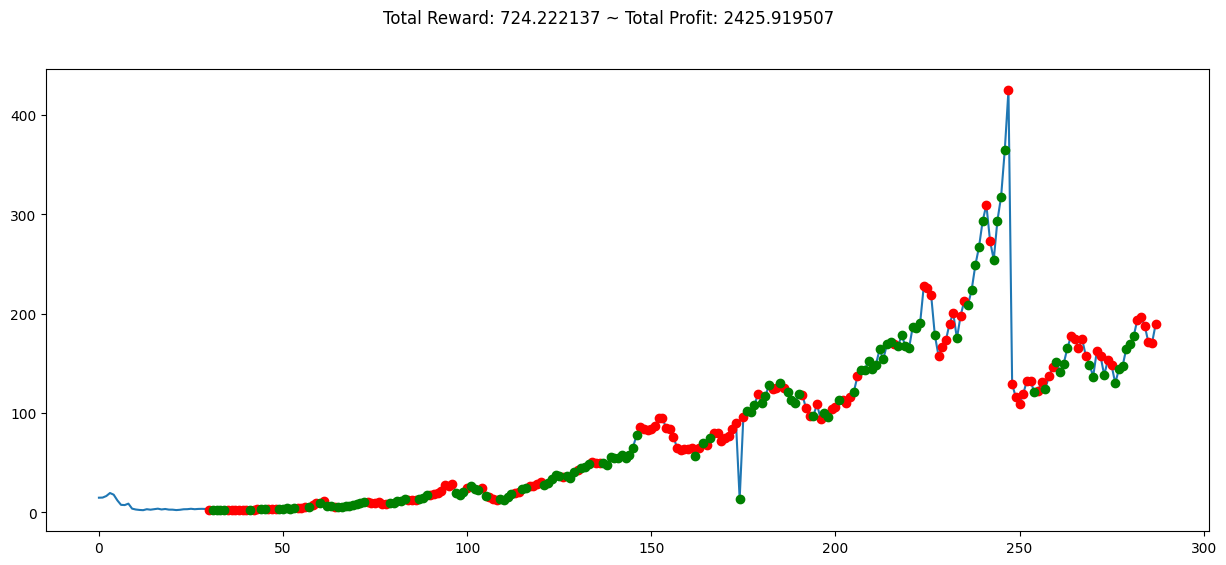

In [137]:
prices, signal_features = personal_process_data(df=df[df['stock_ticker'] == 'AAPL'], window_size=30, stockTickers=stockNames, frame_bound=(30, len(df[df['stock_ticker'] == 'AAPL'])))
env = PersonalStockEnv(prices, signal_features, df=df[df['stock_ticker'] == 'AAPL'], window_size=30, frame_bound=(30, len(df[df['stock_ticker'] == 'AAPL'])))
model = PPO.load("trading_bot")

obs, _ = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _ = model.predict(obs)
    obs, rewards, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done:
        print("info", info)
        break

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()